In [1]:
import tensorflow as tf

In [2]:
import os

In [3]:
import pandas as pd

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
#Getting rid of all the images which cant contribute 
import cv2
import imghdr

In [7]:
train_dir = 'data/train'
val_dir = 'data/validation'
img_height = 56
img_width = 56

In [8]:
# f = pd.read_csv('data/faceexp-comparison-data-train-public.csv')

In [9]:
image_exts = ['jpeg','jpg','bmp','png']
# os.remove(os.path.join(val_dir,'.DS_store'))
os.listdir(train_dir)

['angry', 'fear', 'happy', 'sad', 'surprise']

In [10]:
for image_class in os.listdir(train_dir): 
    for image in os.listdir(os.path.join(train_dir, image_class)):
        image_path = os.path.join(train_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [11]:
for image_class in os.listdir(val_dir): 
    for image in os.listdir(os.path.join(val_dir, image_class)):
        image_path = os.path.join(val_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
# tf.keras??

In [14]:
# tf.keras.utils.image_dataset_from_directory??

In [40]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,image_size=(img_height, img_width))
val_data = tf.keras.utils.image_dataset_from_directory(val_dir,image_size=(img_height, img_width))

Found 23403 files belonging to 5 classes.
Found 5739 files belonging to 5 classes.


In [46]:
class_names = train_data.class_names
print(class_names)
train_re_data=[2]
for i in train_data:
    train_re_data = tf.one_hot(i[1],5)
    

['angry', 'fear', 'happy', 'sad', 'surprise']


In [47]:
print(train_re_data)

tf.Tensor(
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]], shape=(11, 5), dtype=float32)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))


In [20]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.023529414 0.9352543


In [21]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

In [22]:
len(normalized_ds)

732

In [23]:
train_size = int(len(normalized_ds)*.8)
test_size = int(len(normalized_ds)*.2)

In [24]:
train_size + test_size

731

In [25]:
train = normalized_ds.take(train_size)
test = normalized_ds.skip(train_size).take(test_size)

In [26]:
#Building the DNN

In [27]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

In [28]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [29]:
num_classes = len(class_names)

model = Sequential([
    # data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Conv2D(32, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    # layers.Conv2D(64, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    # layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [30]:
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# model.add(MaxPooling2D())

# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 56, 56, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                      

In [33]:
logdir = 'logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [35]:
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20
732/732 [==============================] - 46s 62ms/step - loss: 1.4448 - accuracy: 0.3956 - val_loss: 1.3139 - val_accuracy: 0.4645
Epoch 2/20
732/732 [==============================] - 48s 66ms/step - loss: 1.2563 - accuracy: 0.4883 - val_loss: 1.2712 - val_accuracy: 0.4839
Epoch 3/20
732/732 [==============================] - 47s 65ms/step - loss: 1.1640 - accuracy: 0.5290 - val_loss: 1.2197 - val_accuracy: 0.4989
Epoch 4/20
732/732 [==============================] - 46s 63ms/step - loss: 1.0963 - accuracy: 0.5563 - val_loss: 1.2273 - val_accuracy: 0.5015
Epoch 5/20
732/732 [==============================] - 46s 63ms/step - loss: 1.0291 - accuracy: 0.5899 - val_loss: 1.2085 - val_accuracy: 0.5034
Epoch 6/20
732/732 [==============================] - 49s 67ms/step - loss: 0.9645 - accuracy: 0.6165 - val_loss: 1.2103 - val_accuracy: 0.5170
Epoch 7/20
732/732 [==============================] - 47s 64ms/step - loss: 0.9044 - accuracy: 0.6458 - val_loss: 1.2266 - val_accuracy:

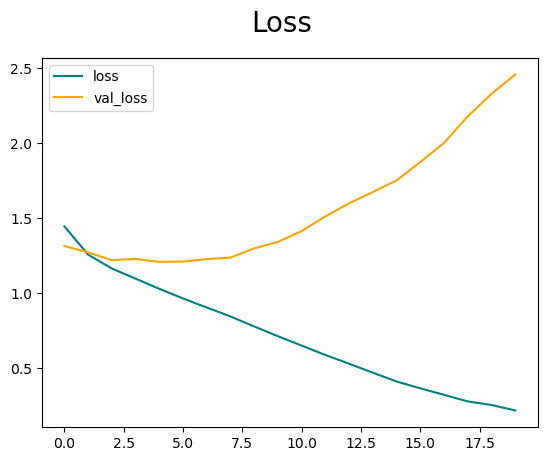

In [36]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

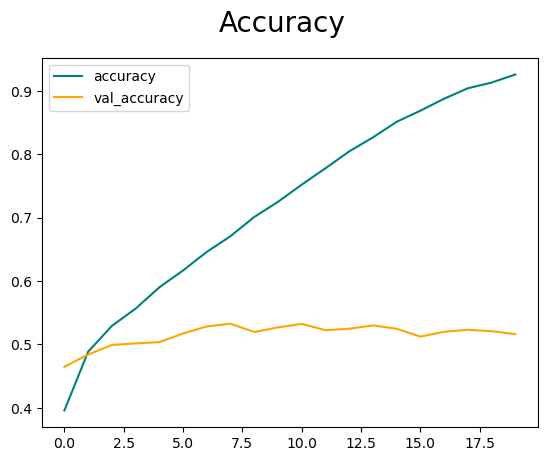

In [37]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [85]:
# Performance Review

In [86]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [87]:
precision = Precision()
recall = Recall()
binAcc = BinaryAccuracy()

In [88]:
# for batch in test.as_numpy_iterator():
#     X, y = batch
#     yhat = model.predict(X)
#     precision.update_state(y,yhat)
#     recall.update_state(y,yhat)
#     binAcc.update_state(y,yhat)

In [89]:
print(f'Precision:{precision.result().numpy()}, {recall.result().numpy()}, {binAcc.result().numpy()}')

Precision:0.0, 0.0, 0.0


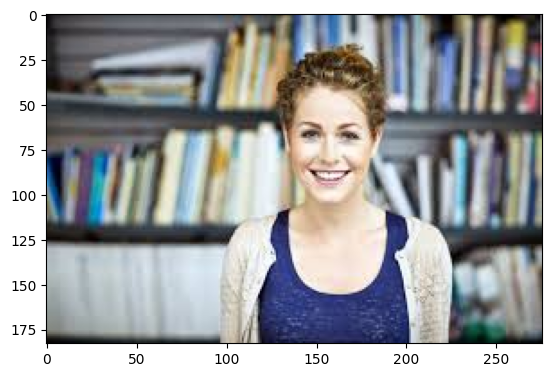

In [90]:
img = cv2.imread('happyTest.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [94]:
happy_dir = "happyTest.jpeg"
img = tf.keras.utils.load_img(
    happy_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 42ms/step
[[ 1.1576339   1.3256993  -1.6588943   1.3914996   0.00686495]]
This image most likely belongs to sad with a 33.05 percent confidence.


In [ ]:
resize = tf.image.resize(img, (img_height,img_width))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

In [ ]:
img = cv2.imread('sadTest.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (img_height,img_width))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

In [ ]:
#saving the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','sentimentClassifier.h5'))